# COMP47590 Advanced Machine Learning
# Using Bottleneck Features from a Pre-trained Model


In this example we build a Convolutional Neural Network with **PyTorch**  to classify images that are stored locally. The dataset used is from Kaggle: 
* cats vs dogs https://www.kaggle.com/c/dogs-vs-cats

This example uses bottleneck features generated from a VGG-16 pre-trained model using which an SVM model is then trained.

In [5]:
import os 
import csv
# import cv2
import random
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torchvision.datasets as datasets
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
from torchvision.models import vgg16, VGG16_Weights

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline 

## Data Loading & Pre-processing

Set up the dataset loading and pre-processing process. We provide the name of a folder containing images. We assume that he images of different classes are contained in folders with class ids.

In [6]:
# Dataset name
dataset_name = 'dogs-vs-cats'

# A sampling rate to allow undersampling for fast execuation
sample_rate = 0.5

# Define proportion of data for test, train and validation splits. 
train_split = 0.5
valid_split = 0.2
test_split = 0.3

# Desired dimensions of our images.
img_width, img_height = 128, 128

Define a Pytorch transformation to resize images to a standard size and convert them to a tensor representation. 

In [7]:
transformations = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor(), # Convert the image to a PyTorch Tensor.
])

Partition the data into train, validation, and test partitions. 

In [8]:
# Load the data
dataset = datasets.ImageFolder("../Data/" + dataset_name + "/", transform = transformations)

# Resample the data set
resampled_size = int(sample_rate * len(dataset))
resampled_dataset, _ = random_split(dataset, [resampled_size, len(dataset) - resampled_size])

# Split the data into train, validation and test sets
test_size = int(test_split * len(resampled_dataset))
train_val_size = int(0.7 * len(resampled_dataset))
train_val_size = len(resampled_dataset) - test_size
train_val_dataset, test_dataset = random_split(resampled_dataset, [train_val_size, test_size])

Create Pytorch **DataLoader** objects to stream train, validation, and test sets. 

In [9]:
batch_size = 32  # Batch size used during training

train_val_loader = DataLoader(dataset=train_val_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

Print a few randomly sampled example images.

In [10]:
items = iter(train_val_loader)
image, label = next(items)

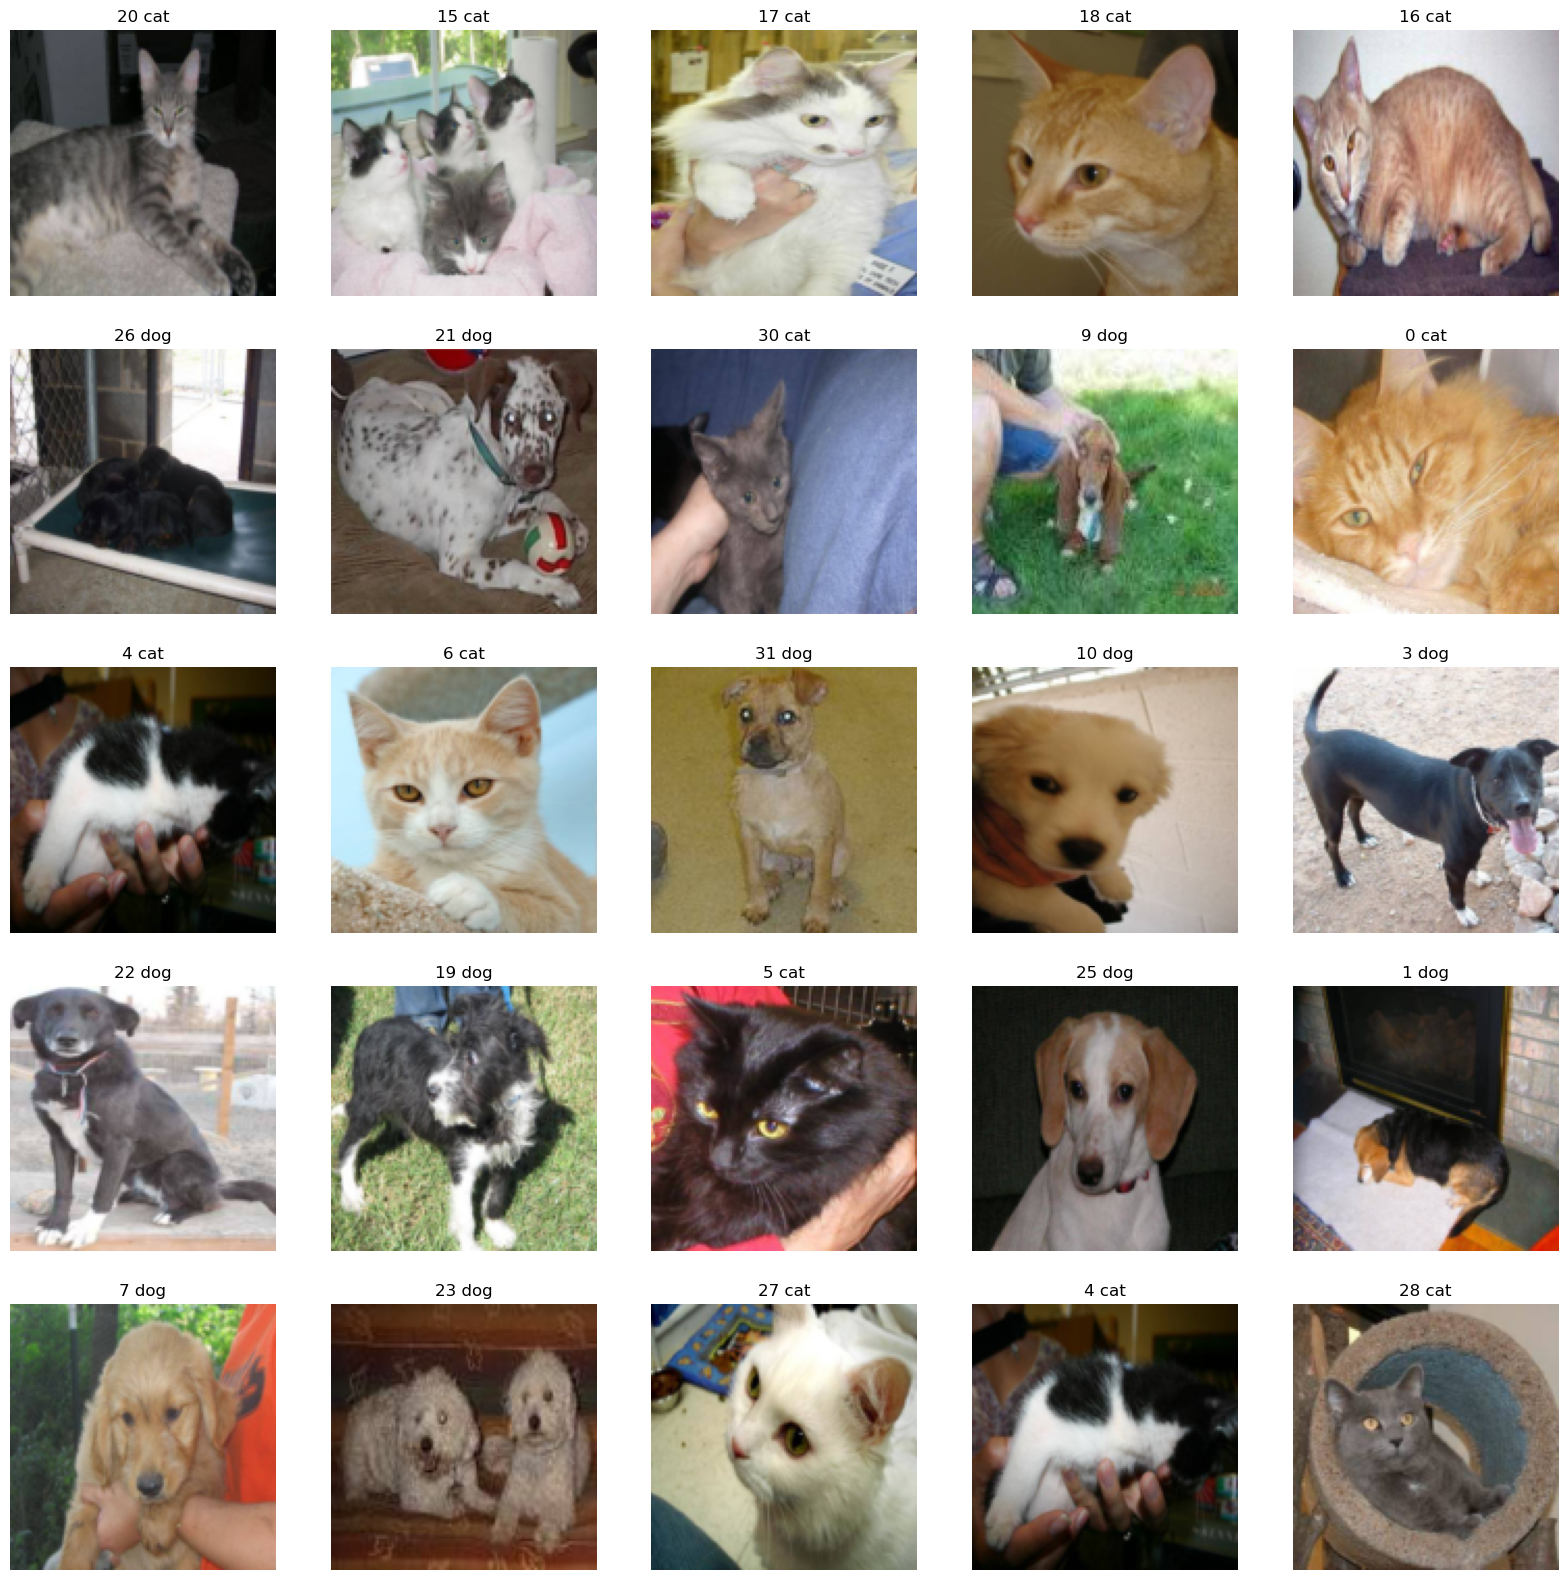

In [11]:
pltsize=4
row_images = 5
col_images = 5
label_names = dataset.classes
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(row_images * col_images):
    i_rand = random.randint(0, len(image) - 1)
    np_image = image.numpy()
    np_label = label.numpy()
    plt.subplot(row_images,col_images,i+1)
    plt.axis('off')
    plt.imshow(np.transpose(np_image[i_rand], (1, 2, 0)))
    plt.title((str(i_rand) + " " + label_names[np_label[i_rand]]))

plt.show()

## Extract Features from Pre-trained Model

First load a **VGG-16 model** pre-trained on the Image Net dataset. 

In [12]:
vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)

model = torch.nn.Sequential(*list(vgg16.features.children())[:-1])

# Set the model to evaluation mode
model.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /Users/lucas/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 144MB/s]  


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

Define a function to push data through the pre-trained model to extract features from it. 

In [13]:
def extract_features(model, dataloader):
    features = []
    labels = []
    for images, label in dataloader:
        with torch.no_grad(): 
            # Pass the image through the VGG16 model
            feature = model(images)
            # Flatten the feature tensor
            feature = torch.flatten(feature, start_dim=1)
            # Append the feature and label to the list
            features.append(feature.numpy())
            labels.append(label.numpy())
            
    # Concatenate the features and labels
    features = np.concatenate(features)
    labels = np.concatenate(labels)

    return features, labels

Use the feature extraction function to generate features from the pre-trained model.

In [14]:
X_train_val, y_train_val = extract_features(model, train_val_loader)
X_test, y_test = extract_features(model, test_loader)

Write the generated data to a file

In [15]:
pd.DataFrame(np.c_[X_train_val, y_train_val]).to_csv('./bottleneck_features_train.csv')
pd.DataFrame(np.c_[X_test, y_test]).to_csv('./bottleneck_features_test.csv')

## Build Model

Build a straight forward scikit-learn model using the generated data. 

In [16]:
clf = svm.SVC(decision_function_shape='ovo')
clf.fit(X_train_val, y_train_val) 

SVC(decision_function_shape='ovo')

Perform some hyper-parameter tuning. 

In [17]:
#tuned_parameters = [{'kernel': ['rbf'], 'decision_function_shape':['ovo'],
#                     'gamma': [1e-3, 1e-4, 1e-5, 1e-6, 1e-7],
#                     'C': [1, 10, 100, 1000]}]
#
#clf = GridSearchCV(svm.SVC(), tuned_parameters, cv=5, verbose=2, n_jobs=-1)
#clf.fit(X_train_val, y_train_val)

## Evaluate Model

Generate a set of performance measures. 

In [18]:
pred = clf.predict(X_test)

print(metrics.classification_report(y_test, pred))

print("Confusion Matrix")
display(pd.crosstab(y_test, pred, rownames=['True'], colnames=['Predicted'], margins=True))

              precision    recall  f1-score   support

           0       0.93      0.96      0.94      1910
           1       0.95      0.93      0.94      1840

    accuracy                           0.94      3750
   macro avg       0.94      0.94      0.94      3750
weighted avg       0.94      0.94      0.94      3750

Confusion Matrix


Predicted     0     1   All
True                       
0          1826    84  1910
1           137  1703  1840
All        1963  1787  3750

View some incorrect and correct predictions. 

In [20]:
items = iter(test_loader)
image, label = next(items)

image = image.numpy()
label = label.numpy()

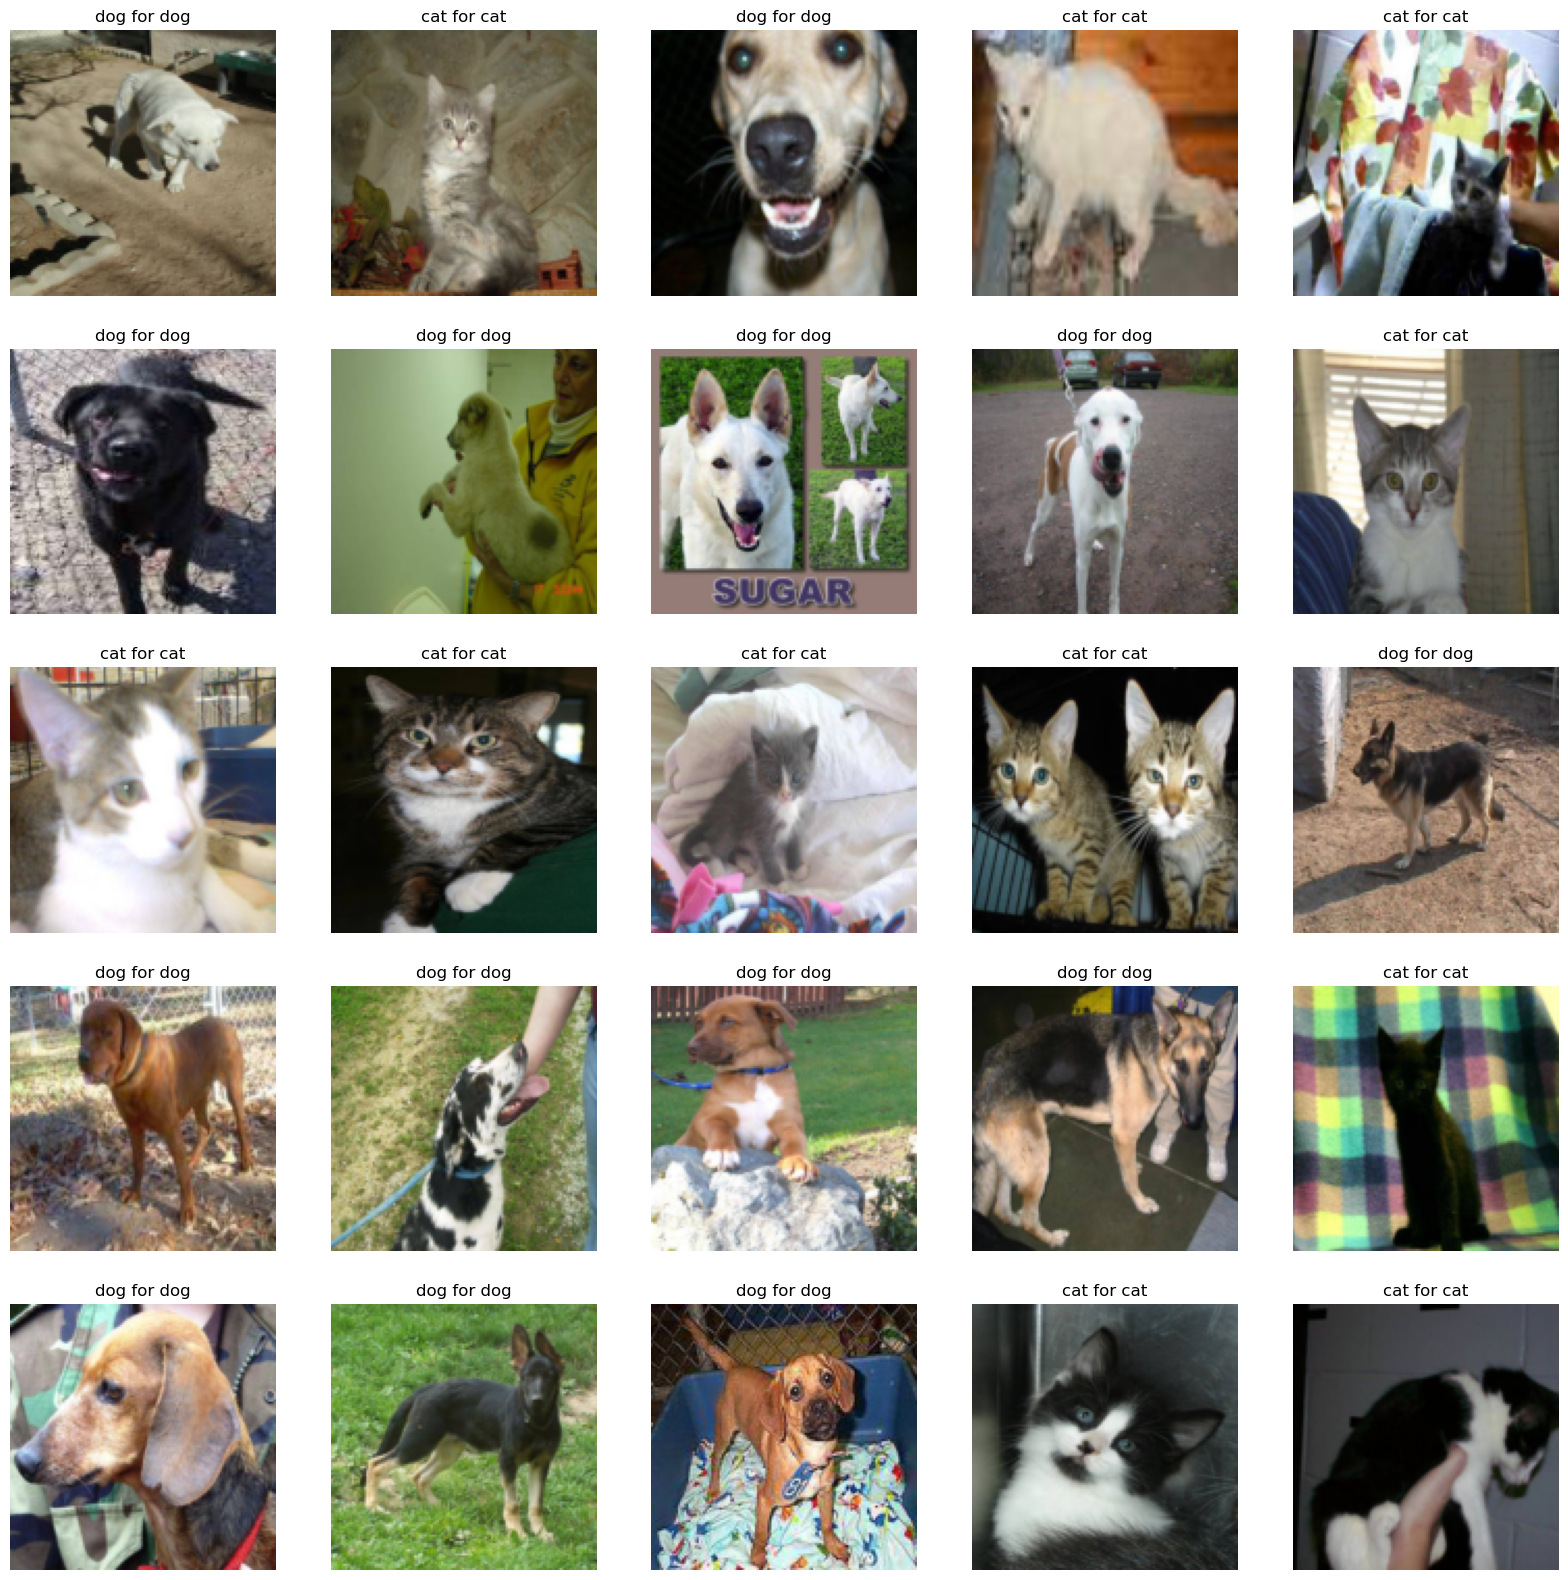

In [21]:
pltsize=4
row_images = 5
col_images = 5

maxtoshow = row_images * col_images
corrects = pred == y_test
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if (corrects[i]):
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(np.transpose(image[i], (1, 2, 0)))
        plt.title("{} for {}".format(label_names[pred[i]], label_names[y_test[i]]))
        ii = ii + 1

plt.show()

In [23]:
pltsize=4
row_images = 5
col_images = 5

maxtoshow = row_images * col_images
errors = pred != y_test
ii = 0
plt.figure(figsize=(col_images*pltsize, row_images*pltsize))

for i in range(X_test.shape[0]):
    if ii>=maxtoshow:
        break
    if errors[i]:
        plt.subplot(row_images,col_images, ii+1)
        plt.axis('off')
        plt.imshow(np.transpose(image[i], (1, 2, 0)))
        plt.title("{} for {}".format(label_names[pred[i]], label_names[y_test[i]]))
        ii = ii + 1

plt.show()

IndexError: index 66 is out of bounds for axis 0 with size 32